In [20]:
import numpy as np
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc

import MFCC_computation as util
reload(util)

%matplotlib inline

In [21]:
import glob
import os

path = os.getcwd() + '/vowels'

VOWELS = glob.glob(path + '/*.wav')
assert len(VOWELS) > 0, ".wav files not found in " + path + " ! Please check the path"

FILES = {
    'natural_male': glob.glob(path + '/nam*.wav'),
    'natural_female': glob.glob(path + '/naf*.wav'),
    'natural_kid': glob.glob(path + '/nk*.wav'),
}

MFCC_COEFFS = 20

### MFCC Visualization

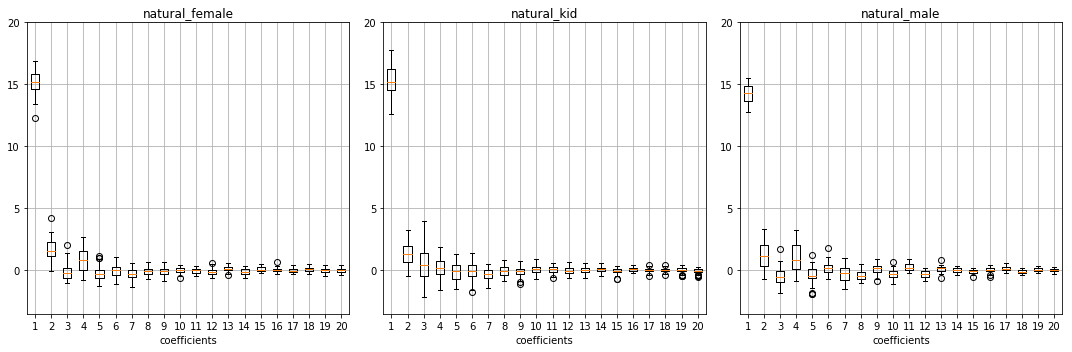

In [22]:
util.print_coeff_boxplot(['natural_female', 'natural_kid', 'natural_male'], FILES, nceps=MFCC_COEFFS, ylim=(-3.5, 20))

## MAN vs. WOMAN vs. KIS

Here we use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker.

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (`EPOCHS`) and number of hidden neurons (`N_NEURONS`).

dataset[0]	[  1.51813605e+01   5.43504237e-01   1.04578408e+00   1.80867812e+00
  -8.01195231e-02  -4.06602434e-01   2.80008987e-01  -2.07164679e-01
  -4.11168060e-01   2.12127628e-03   2.39941083e-02  -2.53485648e-01
   1.22839214e-01  -1.86247773e-01   2.04161990e-01   1.43472789e-03
  -1.70540965e-01   5.23953723e-01  -4.15572899e-01   4.40366133e-01
  -1.00000000e+00   1.00000000e+00  -1.00000000e+00] 

input[0]	[  1.51813605e+01   5.43504237e-01   1.04578408e+00   1.80867812e+00
  -8.01195231e-02  -4.06602434e-01   2.80008987e-01  -2.07164679e-01
  -4.11168060e-01   2.12127628e-03   2.39941083e-02  -2.53485648e-01
   1.22839214e-01  -1.86247773e-01   2.04161990e-01   1.43472789e-03
  -1.70540965e-01   5.23953723e-01  -4.15572899e-01   4.40366133e-01] 

ouput[0]	[-1.  1. -1.] 

testing 8 neurons...
testing 32 neurons...
testing 64 neurons...


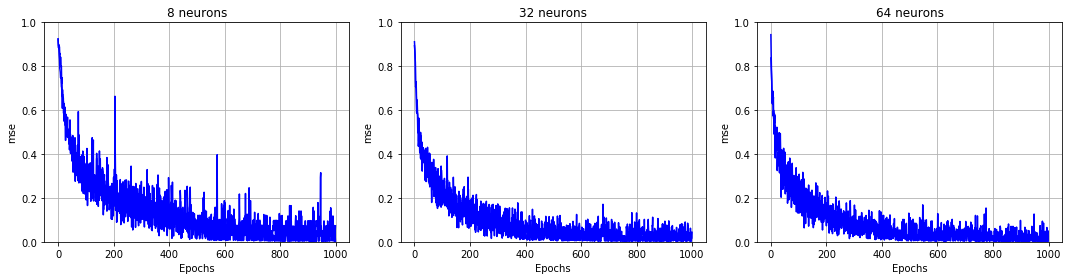

In [46]:
N_INITS = 2
EPOCHS = 1000
N_NEURONS = [8, 32, 64]
LEARNING_RATE = 0.001
MOMENTUM = 0.7

dataset = util.create_dataset(
    [('natural_kid', [1, -1, -1]), ('natural_female', [-1, 1, -1]), ('natural_male', [-1, -1, 1])], FILES, MFCC_COEFFS)

dataset_input = dataset[:, :-3]  # filter only input values (n-1 first values)
dataset_output = dataset[:, -3:]  # filter only the output class (last value)

print "dataset[0]\t", dataset[0], "\n"
print "input[0]\t", dataset_input[0], "\n"
print "ouput[0]\t", dataset_output[0], "\n"

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 3])

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

util.print_mse(MSE, N_NEURONS)

In [33]:
util.create_dataset([('natural_male', 'natural_kid')], FILES)

array([['14.7471046374', '2.06752802488', '-1.30673667638',
        '0.123316603306', '-1.35408721334', '0.73435663736',
        '-0.65883966559', '0.309431068414', '-0.550388656716',
        '0.271125542432', '0.394629728186', '-0.0950813315372',
        '-0.136121320995', 'natural_kid'],
       ['13.6668673245', '0.92137320356', '-1.02247053888',
        '1.07749459767', '-0.561203737699', '-0.264230477508',
        '-0.583927985046', '0.545999861974', '-0.108720087254',
        '0.254659928247', '0.066729358626', '0.152830738152',
        '0.105715702316', 'natural_kid'],
       ['13.6796935141', '1.50603074381', '0.783961843749',
        '0.411354601863', '0.0454019007012', '1.10128161321',
        '0.962363636478', '-0.774964849609', '0.16466423812',
        '-0.439184449163', '0.850091796595', '-0.846050794123',
        '0.0696045721512', 'natural_kid'],
       ['14.0862251706', '-0.0396348568714', '-0.295864250994',
        '2.39449464699', '0.37385097318', '-0.395343299644',
  

In [35]:
EPOCHS = 1000
N_NEURONS = [8, 32, 64]
K = 3

Testing 8 neurons...
Testing 32 neurons...
Testing 64 neurons...


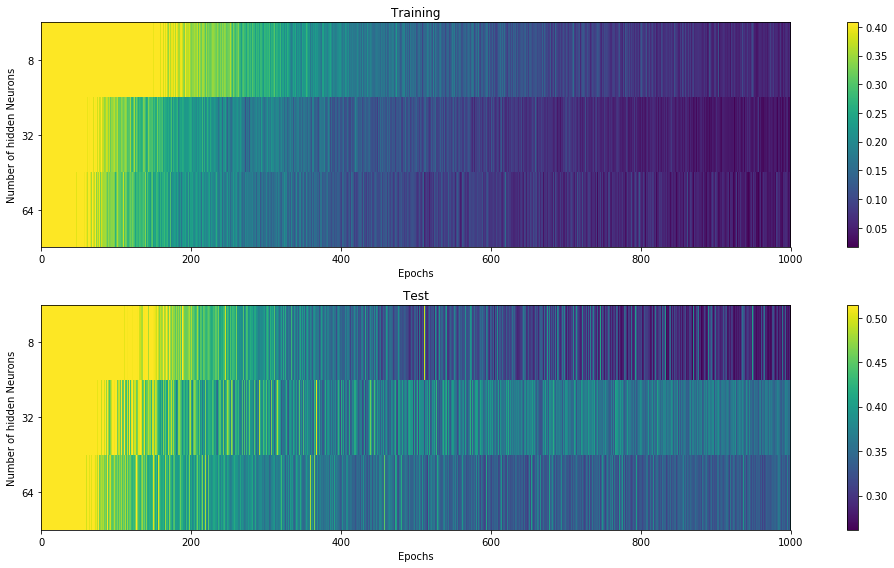

In [36]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))
reload(cv)

for i_h, h in enumerate(N_NEURONS):      # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 3], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=0,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

util.print_mse_train_test(MSE_train, MSE_test, N_NEURONS, aspect=100)

We can see that the result with 8 neurons is good around epoch 800

### Final Model and performance

In [44]:
MOMENTUM = 0.8
EPOCHS = 1000
LEARNING_RATE = 0.001
N_NEURONS = 8
N_INITS = 2

precision:	0.872
recall:	0.868
f1_score:	0.87
MSE training:	0.00968898758686
MSE test:	0.282454928097
Confusion matrix:
[[ 32.   4.   0.]
 [  4.  30.   2.]
 [  0.   4.  30.]]


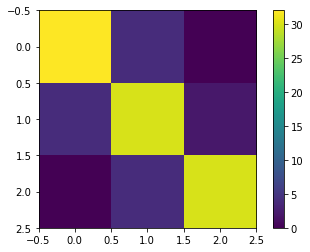

In [45]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 3], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=5,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)

precision, recall, f1_score = util.conf_mat_stats(conf_mat)
print "precision:\t", np.round(precision, 3)
print "recall:\t",    np.round(recall, 3)
print "f1_score:\t",  np.round(f1_score, 3)
print 'MSE training:\t', MSE_train
print 'MSE test:\t', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat

The result has quite a good precision (0.87) and the f1 score is good too.